In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import tree
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle/input/titanic/test.csv
kaggle/input/titanic/train.csv


In [6]:
train_data = pd.read_csv("kaggle/input/titanic/train.csv")
test_data = pd.read_csv("kaggle/input/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder  


device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')


class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        out = self.model(x)
        return out

model = Model(8, 512).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [8]:
def prep_data(data):
    X_Train = data
    X_Train = X_Train.drop(["Ticket"], axis=1)
    X_Train = X_Train.drop(["Cabin"], axis=1)
    X_Train = X_Train.drop(["Embarked"], axis=1)
    X_Train = X_Train.drop(["PassengerId"], axis=1)
    X_Train = X_Train.drop(["Fare"], axis=1)

    X_Train["Age"] = X_Train["Age"].fillna(X_Train["Age"].mean())

    # Replace Age with teen/child/adult columns with a 1 or a 0 
    X_Train["Teen"] = 0
    X_Train["Child"] = 0
    X_Train["Adult"] = 0
    X_Train.loc[X_Train["Age"] < 13, "Child"] = 1
    X_Train.loc[(X_Train["Age"] >= 13) & (X_Train["Age"] < 20), "Teen"] = 1
    X_Train.loc[X_Train["Age"] >= 20, "Adult"] = 1
    X_Train = X_Train.drop(["Age"], axis=1)

    # If rare titles are found in name, add a 1 to the rare field 
    X_Train["Rare"] = 0
    X_Train.loc[X_Train["Name"].str.contains("Lady."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Countess."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Capt."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Col."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Don."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Dr."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Major."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Rev."), "Rare"] = 1
    X_Train.loc[X_Train["Name"].str.contains("Sir."), "Rare"] = 1
    X_Train = X_Train.drop(["Name"], axis=1)

    try:
        X_Train = X_Train.drop(["Survived"], axis=1)
    except:
        pass

    le = LabelEncoder()
    X_Train["Sex"] = le.fit_transform(X_Train["Sex"])
    return X_Train

X_Train = prep_data(train_data)
X_Test = prep_data(test_data)
y = train_data["Survived"]

print(X_Train)
X_Train.describe()

NameError: name 'test_data' is not defined

Epoch:  0 Loss:  0.15736348927021027
Epoch:  1 Loss:  0.08115344494581223
Epoch:  2 Loss:  0.09245029836893082
Epoch:  3 Loss:  0.0952741801738739
Epoch:  4 Loss:  0.03444992005825043
Epoch:  5 Loss:  0.4624072313308716
Epoch:  6 Loss:  0.057896457612514496
Epoch:  7 Loss:  0.27596235275268555
Epoch:  8 Loss:  0.05313756689429283
Epoch:  9 Loss:  0.3257705867290497


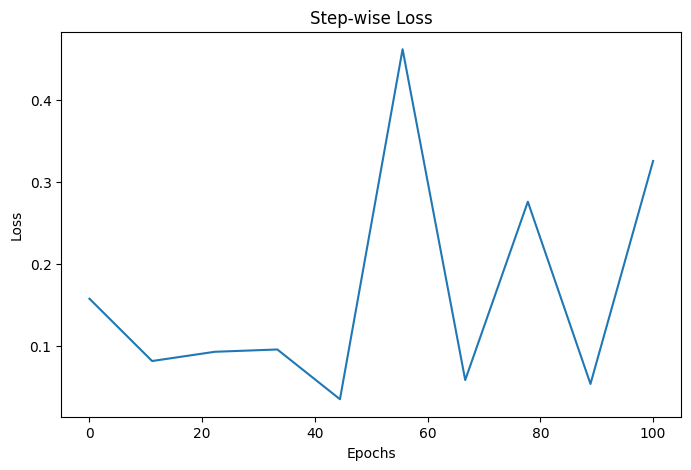

In [ ]:

epoch = 10
loss_values = []
X_Train = torch.from_numpy(X_Train.to_numpy()).float()
X_Test = torch.from_numpy(X_Test.to_numpy()).float()
y = torch.from_numpy(y.to_numpy()).float().unsqueeze(1)

train_data_loader = DataLoader(TensorDataset(X_Train, y), batch_size=1, shuffle=True, pin_memory=True)
test_data_loader = DataLoader(TensorDataset(X_Train, y), batch_size=1, shuffle=True, pin_memory=True)

for n in range(epoch):
    for x, y_test in train_data_loader:
        x = x.to(device)
        y_test = y_test.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = nn.functional.mse_loss(y_pred, y_test)
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())
    print("Epoch: ", n, "Loss: ", loss.item())

step = np.linspace(0, 100, epoch)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
num_right = 0
for x, y_test in test_data_loader:
    x = x.to(device)
    y_test = y_test.to(device)

    y_pred = model(x)
    ypred = int(y_pred.round().item())
    if ypred == y_test.item():
        num_right += 1

print("Accuracy: ", num_right / len(train_data))

Accuracy:  0.7194163860830527


In [ ]:
predictions = []
for n in X_Test:
    n = n.to(device)
    predictions.append(int(model(n).round().item()))

print(predictions)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

submit_data = pd.read_csv("submission.csv")
submit_data.head()

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 